In [1]:
from __future__ import division
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

sns.set()
import random
import sklearn.externals.joblib as jl
import wfdb
from savvyecg import ecg_utils as eu
from savvyecg import ecg_module as em
pd.options.display.max_columns = 200

%matplotlib inline

/Users/eventura/anaconda/envs/ecg/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Load data

In [2]:
data_dir = '../data/physionet/mitdb/'
sample = '124'
sig, fields = wfdb.rdsamp(data_dir+sample)

In [3]:
print(fields['signame'])

['MLII', 'V4']


In [4]:
data_signals = dict([(x, y) for x,y in zip(fields['signame'], sig.T)])
fs = fields['fs']

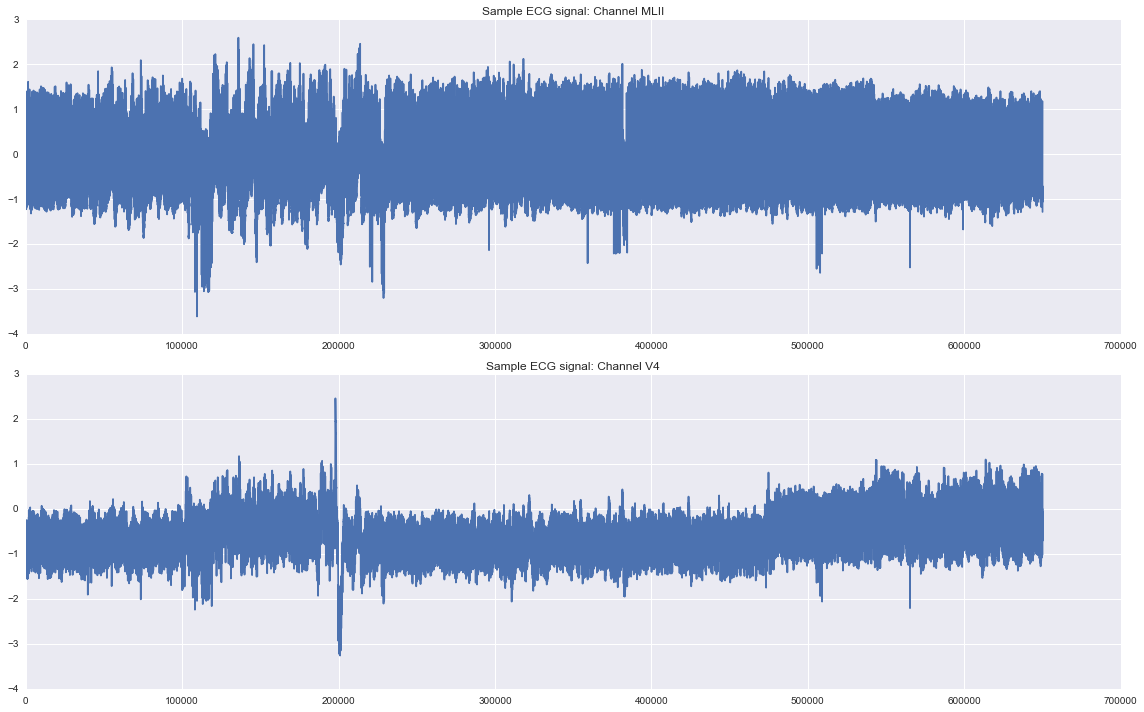

In [5]:
fig, ax = plt.subplots(len(data_signals), figsize = [16, 10])
for i in range(len(data_signals)):
    key = fields['signame'][i]
    ax[i].plot(data_signals[key])
    ax[i].set_title('Sample ECG signal: Channel '+key)
    
plt.tight_layout()
plt.show()

## Preprocessing of an ECG signal

To clean the ECG signal, we perform a series of pre-processing techniques to the raw signal. We perform **(1) high-pass filtering (2) low-pass filtering and, (3) baseline correction**. Locating R peaks is also included in the pre-processing of the ECG signal.


In [6]:
sample_signal = data_signals['V4']
processed_ECG = em.Signal(sample_signal, fs)

In [7]:
# Dataframe containing processed ECG data and R peak locations
ecg_df = processed_ECG.df
ecg_df.head()

,_time_sec,ecg,processed,r_peak
0,0.000000,-0.685,-0.008275,0
1,0.002778,-0.685,-0.008341,0
2,0.005556,-0.685,-0.008400,0
3,0.008333,-0.685,-0.008442,0
4,0.011111,-0.685,-0.008449,0


In [8]:
# Array containing R peak indices
rpeaks = processed_ECG.rpeaks

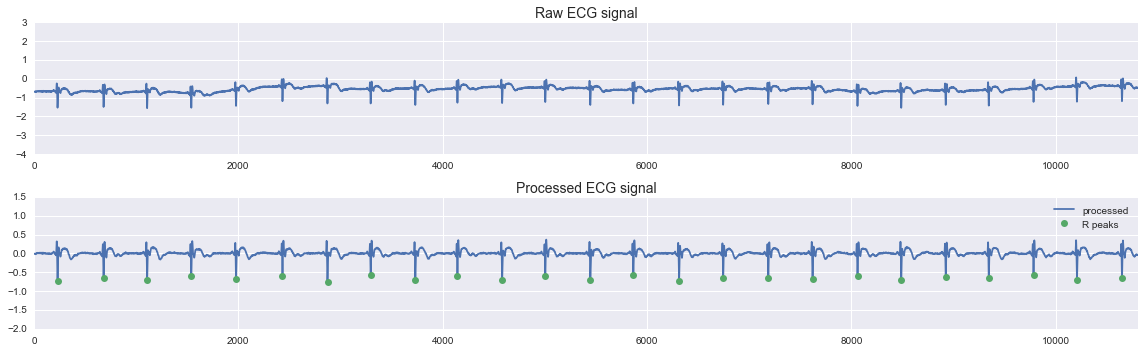

In [9]:
fig, axes = plt.subplots(2, figsize = [16, 5])
ecg_df.ecg.plot(ax=axes[0])
axes[0].set_title('Raw ECG signal', fontsize = 14)
axes[0].set_xlim([0, fs*30])
ecg_df.processed.plot(ax=axes[1])
axes[1].plot(rpeaks, ecg_df.processed.ix[rpeaks], 'o', label = 'R peaks')
axes[1].set_title('Processed ECG signal', fontsize = 14)
axes[1].set_xlim([0, fs*30])
plt.legend()
plt.tight_layout()
plt.show()

## Divide the raw data into windows

In [10]:
# Set size of segment
window_dur = 5 # in seconds
window_size = fs*window_dur

In [11]:
# Tag each datapoint with segment_id
processed_ECG.add_segment_id(window_size, trunc_end=True)
processed_ECG.df.head()

Last segment is shorter than window size was removed.


,_time_sec,ecg,processed,r_peak,segment_id
0,0.000000,-0.685,-0.008275,0,0
1,0.002778,-0.685,-0.008341,0,0
2,0.005556,-0.685,-0.008400,0,0
3,0.008333,-0.685,-0.008442,0,0
4,0.011111,-0.685,-0.008449,0,0


In [12]:
# Dataframe with containing compiled segments
print('Total number of ECG segments: {}'.format(len(processed_ECG.segments_df)))
processed_ECG.segments_df.head()

Total number of ECG segments: 361


,processed
segment_id,
0,"[-0.00827497044573, -0.00834106053754, -0.0083..."
1,"[-0.0046795242659, -0.00885228303984, -0.01130..."
2,"[-0.00908423587526, -0.0124184146543, -0.01095..."
3,"[0.00753046678458, 0.00624071594676, 0.0077191..."
4,"[0.111972713578, 0.0545048448214, 0.0151976367..."


In [13]:
df_ = processed_ECG.segments_df.copy()
df_['r_peaks'] = df_.processed.apply(lambda x: eu.r_peak_loc(np.array(x), int(fs)))
df_ = df_.reset_index(level = 'segment_id', drop = True)

In [14]:
# Compute physiological parameters per segment
processed_ECG.get_segment_features(get_beats=True)
segments_df = processed_ECG.segments_df
segments_df.head()

,processed,r_peaks,hr_permin,hrv_ms,edr,rr_permin,rpeak_beat_pair,beats
segment_id,,,,,,,,
0,"[-0.00827497044573, -0.00834106053754, -0.0083...","[230, 680, 1107, 1539]",49.503438,27.436171,"[-0.0481924831703, -0.0480368740718, -0.047881...",16.488550,"[(230, [0.0383362839255, 0.0324801078686, 0.02...","[[0.0383362839255, 0.0324801078686, 0.02783482..."
1,"[-0.0046795242659, -0.00885228303984, -0.01130...","[177, 631, 1072, 1494]",49.202733,36.500747,"[-0.0279213865737, -0.0277305209411, -0.027539...",16.388467,"[(177, [0.0542168610076, 0.0500006330662, 0.04...","[[0.0542168610076, 0.0500006330662, 0.04339414..."
2,"[-0.00908423587526, -0.0124184146543, -0.01095...","[131, 544, 981, 1403]",50.943396,27.498597,"[-0.0496305672387, -0.0493835660858, -0.049136...",16.967793,"[(131, [0.0463273651008, 0.0384575784858, 0.02...","[[0.0463273651008, 0.0384575784858, 0.02961562..."
3,"[0.00753046678458, 0.00624071594676, 0.0077191...","[44, 465, 913, 1344, 1786]",49.598163,28.767104,"[-0.049205447186, -0.0488822926215, -0.0485591...",12.392427,"[(44, [0.0493058208058, 0.0425723404252, 0.031...","[[0.0493058208058, 0.0425723404252, 0.03167596..."
4,"[0.111972713578, 0.0545048448214, 0.0151976367...","[419, 859, 1287, 1723]",49.693252,13.857990,"[-0.0314356901056, -0.0312602766463, -0.031084...",16.551724,"[(419, [0.0570849512937, 0.0463956329237, 0.03...","[[0.0570849512937, 0.0463956329237, 0.03352841..."


In [15]:
## Perform classification

In [16]:
df_out = em.classify_signalquality(segments_df, fs)

Processing...
Computing features...
Done!


In [17]:
bad_signals = np.vstack(df_out.processed[df_out.quality == 0].values)
good_signals = np.vstack(df_out.processed[df_out.quality == 1].values)

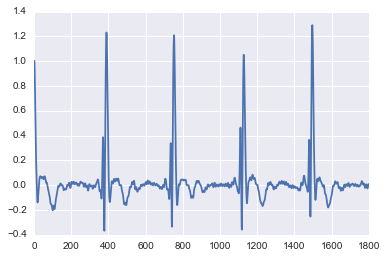

In [18]:
plt.plot(bad_signals[-1])

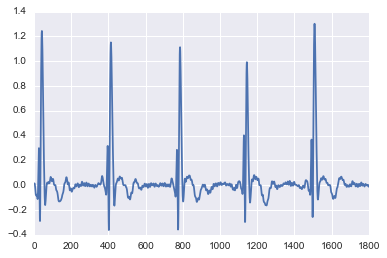

In [19]:
plt.plot(good_signals[-1])

In [20]:
processed_data_labeled = pd.merge(processed_ECG.df, df_out.reset_index().filter(['segment_id', 'quality']))

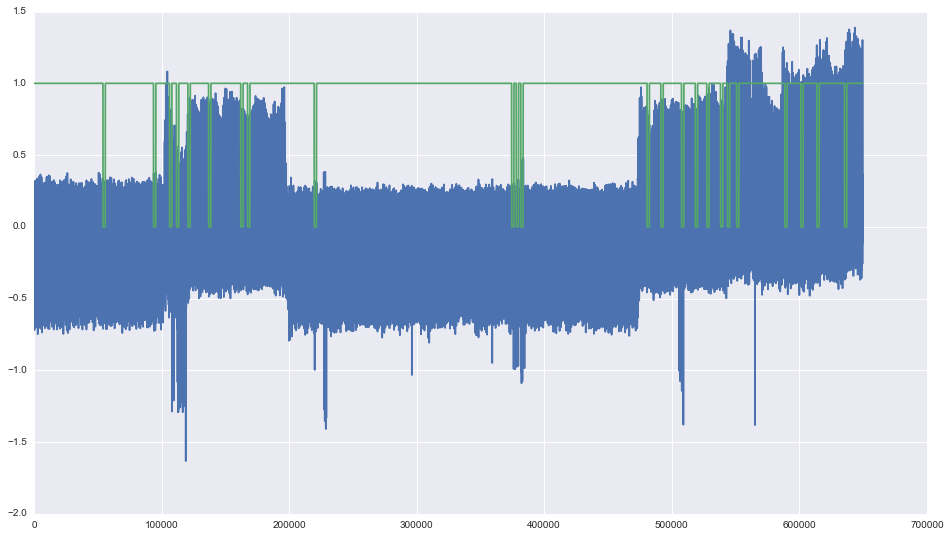

In [23]:
plt.figure(figsize=[16, 9])
plt.plot(processed_data_labeled.processed.values)
plt.plot(processed_data_labeled.quality.values)
